In [1]:
import numpy as np
from scipy import signal
from scipy.io.wavfile import read
from IPython.display import Audio
import matplotlib.pyplot as plt
from numpy.fft import fft
from bitarray import bitarray

In [2]:
def downsample_4k(data, fs):
    return signal.resample_poly(data, 1, 11)

def bandpass(data):
    b = signal.firls(25, [0, 250, 300, 2000], [0, 0, 1, 1], fs=4000)
    w, h = signal.freqz(b)
    plt.plot(w, 20*np.log10(abs(h)))
    return signal.lfilter(b, 1, data)

def stft(data, win_len=100, win_overlap=10):
    frame_start = 0
    
    win_len_frames = 4000 * win_len // 1000
    win_overlap_frames = 4000 * win_overlap // 1000
    
    num_frames = data.shape[0] // win_overlap_frames
    print(data.shape)
    print(num_frames)

    stft_out = np.zeros((num_frames, win_len_frames//2))
    frame = np.zeros(win_len_frames)
    fft_frame = np.zeros(win_len_frames)
    
    for i in range(num_frames):
        frame_start = i * win_overlap_frames
        win = np.hamming(win_len_frames)
        if frame_start + win_len_frames >= data.shape[0]:
            frame[0:data.shape[0]-frame_start] = data[frame_start:]
            frame = frame * win
        else:
            frame = win * data[frame_start : frame_start + win_len_frames]
        fft_frame = abs(fft(frame))
        stft_out[i,:] = np.square(np.abs(fft_frame[:win_len_frames//2])) / win_len_frames
            
    return stft_out

def compute_mel(data, nbins=18):
    low_mfreq = 0
    hi_mfreq = 2595 * np.log10(1 + 2000/700)
    m_points = np.linspace(low_mfreq, hi_mfreq, nbins + 2)
    hz_points = (700 * (10**(m_points / 2595) - 1))
    
    bin = (4000*100//1000 + 1) * hz_points / 4000
    f_bank = np.zeros((nbins, 4000*100//1000 // 2))
    
    for m in range(1, nbins + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            f_bank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            f_bank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    f_bank = np.where(f_bank < 0, 0, f_bank)

    filter_banks = np.dot(data, f_bank.T)
    filter_banks = np.where(filter_banks <= 0, np.finfo(float).eps, filter_banks)
    return 20 * np.log10(filter_banks)

def find_peaks(data):
    print(data.shape)

In [3]:
fs, data = read('test_songs/Moonage.wav')
if (data.shape[1] != 1):
    data = data[:,0]
print(fs)
print(data.shape)

44100
(12342528,)


(12342528,)
(1122048,)


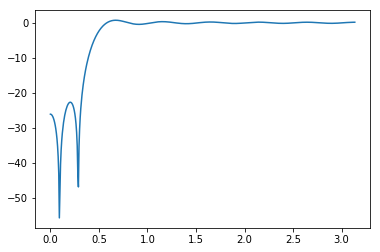

In [4]:
# apply downsampling
data_2 = downsample_4k(data, fs)
print(data.shape)
print(data_2.shape)
# apply bandpass
data_3 = bandpass(data_2)

(1122048,)
28051


/home/evan/ece420/ece420/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


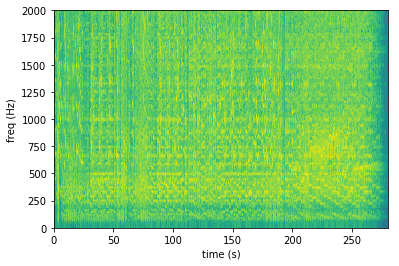

In [5]:
# compute stft

stft_out = stft(data_3)

scales = [np.linspace(0, data_3.size/4000, stft_out.shape[0]+1), np.linspace(0, 4000/2, stft_out.shape[1]+1)]

plt.figure()
plt.pcolormesh(scales[0], scales[1], 20*np.log10(stft_out.T))
plt.xlabel('time (s)')
plt.ylabel('freq (Hz)')
plt.axis('tight')
plt.show()

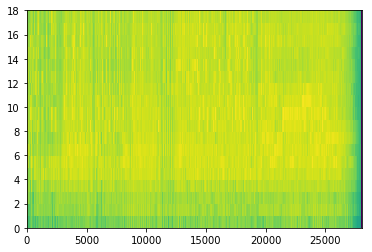

In [6]:
# apply mel filter bank

mels = compute_mel(stft_out)
plt.pcolormesh(mels.T)
plt.show()

In [7]:
peaks = [[] for i in range(mels.shape[1])]

db = {}

for t in range(9, mels.shape[0]-9):
    for b in range(1, mels.shape[1]-1):
        # test neighbors
        if mels[t,b] <= mels[t-1][b]:
            continue
        if mels[t,b] <= mels[t+1][b]:
            continue
        if mels[t,b] <= mels[t][b-1]:
            continue
        if mels[t,b] <= mels[t][b+1]:
            continue
            
        # add peak if it's the first one in band
        # if len(peaks[b]) == 0 or True:
        peaks[b].append(t)
        # continue
            
        # check threshold
        # skip for now
        
        # compute region values
        # region 1
        r_1a = (mels[t-9][b] + mels[t-8][b] + mels[t-7][b]) / 3
        r_1b = (mels[t-7][b] + mels[t-6][b] + mels[t-5][b]) / 3
        r_1c = (mels[t-5][b] + mels[t-4][b] + mels[t-3][b]) / 3
        r_1d = (mels[t-3][b] + mels[t-2][b] + mels[t-1][b]) / 3
        r_1e = (mels[t+1][b] + mels[t-2][b] + mels[t-3][b]) / 3
        r_1f = (mels[t+3][b] + mels[t-4][b] + mels[t-5][b]) / 3
        r_1g = (mels[t+5][b] + mels[t-6][b] + mels[t-7][b]) / 3
        r_1h = (mels[t+7][b] + mels[t-8][b] + mels[t-8][b]) / 3
        
        # region 2
        if b == mels.shape[1] - 2:
            r_2a = (mels[t-1][b+1] + mels[t][b+1] + mels[t+1][b+1]) / 3
        else:
            r_2a = (mels[t-1][b+2] + mels[t][b+2] + mels[t+1][b+2]) / 3
        r_2b = (mels[t-1][b+1] + mels[t][b+1] + mels[t+1][b+1]) / 3
        r_2c = (mels[t-1][b-1] + mels[t][b-1] + mels[t+1][b-1]) / 3
        if b == 1:
            r_2d = (mels[t-1][b-1] + mels[t][b-1] + mels[t+1][b-1]) / 3
        else:
            r_2d = (mels[t-1][b-2] + mels[t][b-2] + mels[t+1][b-2]) / 3
            
        # region 3
        r_3a = (mels[t-2][b+1] + mels[t-1][b+1] + mels[t][b+1] + mels[t-2][b] + mels[t-1][b]) / 5
        r_3b = (mels[t][b+1] + mels[t+1][b+1] + mels[t+2][b+1] + mels[t+1][b] + mels[t+2][b]) / 5
        r_3c = (mels[t+1][b] + mels[t+2][b] + mels[t][b-1] + mels[t+1][b-1] + mels[t+2][b-1]) / 5
        r_3d = (mels[t-2][b] + mels[t-1][b] + mels[t-2][b-1] + mels[t-1][b-1] + mels[t][b-1]) / 5
        
        # region 4
        if b == mels.shape[1] - 2:
            r_4a = (mels[t-9][b+1] + mels[t-8][b+1] + mels[t-7][b+1] + mels[t-6][b+1]) / 4
            r_4b = (mels[t-5][b+1] + mels[t-4][b+1] + mels[t-3][b+1] + mels[t-2][b+1]) / 4
            r_4e = (mels[t+5][b+1] + mels[t+4][b+1] + mels[t+3][b+1] + mels[t+2][b+1]) / 4
            r_4f = (mels[t+9][b+1] + mels[t+8][b+1] + mels[t+7][b+1] + mels[t+6][b+1]) / 4
        else:
            r_4a = (mels[t-9][b+2] + mels[t-8][b+2] + mels[t-7][b+2] + mels[t-6][b+2] + mels[t-9][b+1] + mels[t-8][b+1] + mels[t-7][b+1] + mels[t-6][b+1]) / 8
            r_4b = (mels[t-5][b+2] + mels[t-4][b+2] + mels[t-3][b+2] + mels[t-2][b+2] + mels[t-5][b+1] + mels[t-4][b+1] + mels[t-3][b+1] + mels[t-2][b+1]) / 8
            r_4e = (mels[t+5][b+2] + mels[t+4][b+2] + mels[t+3][b+2] + mels[t+2][b+2] + mels[t+5][b+1] + mels[t+4][b+1] + mels[t+3][b+1] + mels[t+2][b+1]) / 8
            r_4f = (mels[t+9][b+2] + mels[t+8][b+2] + mels[t+7][b+2] + mels[t+6][b+2] + mels[t+9][b+1] + mels[t+8][b+1] + mels[t+7][b+1] + mels[t+6][b+1]) / 8
        if b == 1:
            r_4c = (mels[t-9][b-1] + mels[t-8][b-1] + mels[t-7][b-1] + mels[t-6][b-1]) / 4
            r_4d = (mels[t-5][b-1] + mels[t-4][b-1] + mels[t-3][b-1] + mels[t-2][b-1]) / 4
            r_4g = (mels[t+5][b-1] + mels[t+4][b-1] + mels[t+3][b-1] + mels[t+2][b-1]) / 4
            r_4h = (mels[t+9][b-1] + mels[t+8][b-1] + mels[t+7][b-1] + mels[t+6][b-1]) / 4
        else:
            r_4c = (mels[t-9][b-2] + mels[t-8][b-2] + mels[t-7][b-2] + mels[t-6][b-2] + mels[t-9][b-1] + mels[t-8][b-1] + mels[t-7][b-1] + mels[t-6][b-1]) / 8
            r_4d = (mels[t-5][b-2] + mels[t-4][b-2] + mels[t-3][b-2] + mels[t-2][b-2] + mels[t-5][b-1] + mels[t-4][b-1] + mels[t-3][b-1] + mels[t-2][b-1]) / 8
            r_4g = (mels[t+5][b-2] + mels[t+4][b-2] + mels[t-3][b-2] + mels[t+2][b-2] + mels[t+5][b-1] + mels[t+4][b-1] + mels[t+3][b-1] + mels[t+2][b-1]) / 8
            r_4h = (mels[t+9][b-2] + mels[t+8][b-2] + mels[t+7][b-2] + mels[t+6][b-2] + mels[t+9][b-1] + mels[t+8][b-1] + mels[t+7][b-1] + mels[t+6][b-1]) / 8


        bits = [False for _ in range(22)]
        # compute bits
        
        # horizontal max
        bits[0] = r_1a > r_1b
        bits[1] = r_1b > r_1c
        bits[2] = r_1c > r_1d
        bits[3] = r_1d > r_1e
        bits[4] = r_1e > r_1f
        bits[5] = r_1f > r_1g
        bits[6] = r_1g > r_1h

        # vertical max
        bits[7] = r_2a > r_2b
        bits[8] = r_2b > r_2c
        bits[9] = r_2c > r_2d
        
        # intermediate quadrants
        bits[10] = r_3a > r_3b
        bits[11] = r_3d > r_3c
        bits[12] = r_3a > r_3d
        bits[13] = r_3b > r_3c
        
        # extended quadrants 1
        bits[14] = r_4a > r_4b
        bits[15] = r_4c > r_4d
        bits[16] = r_4e > r_4f
        bits[17] = r_4g > r_4h
        
        # extended quardants 2
        bits[18] = r_4a + r_4b > r_4c + r_4d
        bits[19] = r_4e + r_4f > r_4g + r_4h
        bits[20] = r_4c + r_4d > r_4e + r_4f
        bits[21] = r_4a + r_4b > r_4g + r_4h
        
        # calculate binary representation of band
        band_bits = [True for _ in range(4)]
        band_bits[0] = False if (b-1) & 0x8 == 0 else True
        band_bits[1] = False if (b-1) & 0x4 == 0 else True
        band_bits[2] = False if (b-1) & 0x2 == 0 else True
        band_bits[3] = False if (b-1) & 0x1 == 0 else True
        
        # add fingerprint to database
        fp = bitarray(band_bits + bits)
        if str(fp) in db:
            db[str(fp)].append(t)
        else:
            db[str(fp)] = [t]

In [8]:
for k,v in db.items():
    print('db[{}] = {}'.format(k,v))

db[bitarray('11111111100001110011000000')] = [10]
db[bitarray('00000000111010001100011100')] = [21]
db[bitarray('10010000111001000000100000')] = [22]
db[bitarray('01010001111101010000110100')] = [23]
db[bitarray('11100001111011111100111101')] = [27, 14655]
db[bitarray('00011100100111011111011101')] = [29, 18225]
db[bitarray('01011101111101100001101001')] = [31]
db[bitarray('01110000111010011111100011')] = [34]
db[bitarray('11011110011110011111011101')] = [35]
db[bitarray('01000001111011000110011101')] = [39]
db[bitarray('11110001111001000010100010')] = [41]
db[bitarray('11100000111011001101011101')] = [46]
db[bitarray('01010000111101000010110010')] = [52]
db[bitarray('11111001110011101001111001')] = [58]
db[bitarray('01111000111010011100110010')] = [59]
db[bitarray('01010001111101110010010010')] = [68]
db[bitarray('11111001111001100011010010')] = [73]
db[bitarray('00010001111101100010011101')] = [78, 1772]
db[bitarray('11100001111011101111001101')] = [79, 17360]
db[bitarray('0111000011

db[bitarray('01001100100011011101100010')] = [3274]
db[bitarray('11110001111001010100110100')] = [3275, 8489]
db[bitarray('10110001111100110011110010')] = [3280]
db[bitarray('00110000111011001110111101')] = [3283, 18451]
db[bitarray('10101000110000010011010010')] = [3286]
db[bitarray('11011001110010001111001100')] = [3291]
db[bitarray('10001001110011111111001000')] = [3292]
db[bitarray('11100001100101010011001100')] = [3292]
db[bitarray('10110001111100000001000010')] = [3293]
db[bitarray('01000111001001110011000100')] = [3294]
db[bitarray('00001000111110101100111101')] = [3295, 10247, 13456, 17572, 18240, 21542, 24719]
db[bitarray('01001100101001000000110101')] = [3300]
db[bitarray('01110001111100010010110100')] = [3300]
db[bitarray('10100001111101000000010100')] = [3303, 6646]
db[bitarray('01000011011001110001111111')] = [3305]
db[bitarray('10010010011010111101101101')] = [3308]
db[bitarray('11000001111110111100001101')] = [3313]
db[bitarray('11100001111000010110000000')] = [3313]
db[

db[bitarray('11110001111010101101000010')] = [6850]
db[bitarray('00111101100111111110111101')] = [6851]
db[bitarray('01110100101010111100110111')] = [6853]
db[bitarray('01000111000011111111001101')] = [6857]
db[bitarray('11100000111011011111111101')] = [6858]
db[bitarray('01110100101010101101000010')] = [6859]
db[bitarray('11111100100001010010110111')] = [6859]
db[bitarray('00011100100111011111001101')] = [6862]
db[bitarray('01010000110110001100101000')] = [6866]
db[bitarray('00110001111111101100011101')] = [6868]
db[bitarray('01111001110010011100000011')] = [6869]
db[bitarray('01110000110010011101010111')] = [6872]
db[bitarray('11100001111011101100111101')] = [6872]
db[bitarray('01001000111001010010111101')] = [6874]
db[bitarray('01110000111001010010111010')] = [6888]
db[bitarray('10101000110100010001110010')] = [6888]
db[bitarray('11001001111110001100111101')] = [6888]
db[bitarray('01001001110101100000101000')] = [6889]
db[bitarray('00111000110011101100101101')] = [6890]
db[bitarray(

db[bitarray('00000001111110111101101101')] = [11519, 20814, 23481, 26081]
db[bitarray('00110000111111101110111101')] = [11519]
db[bitarray('10011001111100110000110011')] = [11519]
db[bitarray('00101110000010001111011101')] = [11529]
db[bitarray('00001000111110111110101101')] = [11530]
db[bitarray('10000000111100000000110010')] = [11538, 12906]
db[bitarray('01101001111111001100111101')] = [11539]
db[bitarray('11000001111011111100110101')] = [11540]
db[bitarray('00111001111111111101111111')] = [11541]
db[bitarray('11110000111010001100110000')] = [11559]
db[bitarray('01000001111111101000111000')] = [11560]
db[bitarray('01100000111110000100110101')] = [11560]
db[bitarray('11001001110001100000111000')] = [11560]
db[bitarray('00110000111011111000111101')] = [11562]
db[bitarray('11001111000101110011000000')] = [11571]
db[bitarray('01010000111011111000100100')] = [11582]
db[bitarray('10000000111000110000110000')] = [11582]
db[bitarray('11000001111111101100110100')] = [11583]
db[bitarray('11100

db[bitarray('10011101100000110011100010')] = [15627]
db[bitarray('00111101100111111101011101')] = [15628]
db[bitarray('01101100100001000011010010')] = [15633]
db[bitarray('11101100110011111111001101')] = [15634]
db[bitarray('00111111100111111111111101')] = [15635]
db[bitarray('01100000111011011101000100')] = [15641]
db[bitarray('10010000111000000000000010')] = [15642]
db[bitarray('11111001110011111101000010')] = [15642]
db[bitarray('11010000111010010110101101')] = [15648]
db[bitarray('10000001111101100010100010')] = [15651]
db[bitarray('10110000111101100001111011')] = [15652]
db[bitarray('01010000111101000010111101')] = [15655]
db[bitarray('10100000111010101111110010')] = [15655]
db[bitarray('01001001111011101100111101')] = [15657]
db[bitarray('01110000111010111100111101')] = [15658]
db[bitarray('00001100000110001111111101')] = [15661]
db[bitarray('01110010111010011111111111')] = [15663]
db[bitarray('00001001111110101111011101')] = [15664]
db[bitarray('11100000111001110011100010')] = [

db[bitarray('00111101100111001110011101')] = [19936]
db[bitarray('11011100100011101111001101')] = [19939]
db[bitarray('00101101100110111100001101')] = [19940]
db[bitarray('01111000110001100011100010')] = [19941]
db[bitarray('00001111000110011100011101')] = [19945]
db[bitarray('01100000111001000010111101')] = [19946]
db[bitarray('10101000110010011100100000')] = [19947]
db[bitarray('11011000100110001100101100')] = [19947]
db[bitarray('11110001111000010000110010')] = [19949]
db[bitarray('00000110011110011101011101')] = [19950]
db[bitarray('00110100101111101100101101')] = [19953]
db[bitarray('11010101111101000000111111')] = [19954]
db[bitarray('01101100100011111111001111')] = [19959]
db[bitarray('00110100111011011110011101')] = [19960]
db[bitarray('11110001111000110001110010')] = [19964]
db[bitarray('00000100100110101110001101')] = [19965]
db[bitarray('01100101111011001111101100')] = [19965]
db[bitarray('11010001110010010100001101')] = [19968]
db[bitarray('10100001111010101100010010')] = [

db[bitarray('01010111011101100001001001')] = [24459]
db[bitarray('10100001100100010000100010')] = [24462]
db[bitarray('11001101111100100000110010')] = [24465]
db[bitarray('10100101101100100001110010')] = [24468]
db[bitarray('10001110000101010001101101')] = [24469]
db[bitarray('11110000111001111001011111')] = [24470]
db[bitarray('00001100100100100010001101')] = [24473]
db[bitarray('10100001111100110010100010')] = [24473]
db[bitarray('10000110000110101101111001')] = [24475]
db[bitarray('01011110000011001111111101')] = [24476]
db[bitarray('00000101101100010010011101')] = [24480]
db[bitarray('01100000110101101000111001')] = [24481]
db[bitarray('10101110100000000011100010')] = [24483]
db[bitarray('10001001100110011110101111')] = [24484]
db[bitarray('11000000110100000001110010')] = [24485]
db[bitarray('00000101111110110101111101')] = [24486]
db[bitarray('11100000110010001110001100')] = [24486]
db[bitarray('01010001111011111111001101')] = [24488]
db[bitarray('10001100110010101101111011')] = [